# Frozen Smoke Geography

**Purpose:** Map the spatial structure of the frozen smoke—core vs Oort Cloud, distance distributions, voids.

---

## The Solar System Analogy

The frozen smoke has two distinct zones:

| Zone | Definition | Character |
|------|------------|----------|
| **Core** | L2 < 0.00005 from center | Dense. Black holes live here. |
| **Oort Cloud** | L2 ≥ 0.00005 | Sparse. All singletons. |

The boundary between them is *sharp*—density drops from ~26 to exactly 1.

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from transformers import AutoTokenizer

# Paths
DATA_DIR = Path("../../../tensors/Qwen3-4B-Instruct-2507")

# Load data
W = load_file(DATA_DIR / "W_unembed.safetensors")['W'].view(torch.bfloat16)
masks = load_file(DATA_DIR / "masks.safetensors")
neighborhood_mask = masks['neighborhood_mask']

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen3-4B-Instruct-2507")

print(f"Total vocabulary: {len(W):,}")
print(f"Neighborhood tokens: {neighborhood_mask.sum().item():,}")

Total vocabulary: 151,936
Neighborhood tokens: 2,212


In [2]:
# Extract unique vectors
neighborhood_indices = torch.where(neighborhood_mask)[0]
W_neighborhood = W[neighborhood_indices]

unique_bits, inverse_indices, counts = torch.unique(
    W_neighborhood.view(torch.uint16).to(torch.int32), dim=0,
    return_inverse=True, return_counts=True
)

# Convert to float for distance calculations
unique_bf16 = unique_bits.to(torch.uint16).view(torch.bfloat16)
W_unique = unique_bf16.float()

n_unique = len(unique_bits)
print(f"Unique vectors: {n_unique}")

# Identify center (biggest black hole)
center_idx = counts.argmax().item()
center_count = counts[center_idx].item()
print(f"Center: vector {center_idx} with {center_count} tokens")

Unique vectors: 125
Center: vector 40 with 814 tokens


## Distance from Center

In [3]:
# Compute L2 distances from center
r = torch.norm(W_unique - W_unique[center_idx], dim=1).numpy()

print(f"Distance range: [{r.min():.6f}, {r.max():.6f}]")
print(f"Mean: {r.mean():.6f}")
print(f"Median: {np.median(r):.6f}")
print()

# Distance percentiles
for p in [50, 75, 90, 95, 99]:
    print(f"{p}th percentile: {np.percentile(r, p):.6f}")

Distance range: [0.000000, 0.005495]
Mean: 0.000146
Median: 0.000035

50th percentile: 0.000035
75th percentile: 0.000089
90th percentile: 0.000316
95th percentile: 0.000490
99th percentile: 0.001034


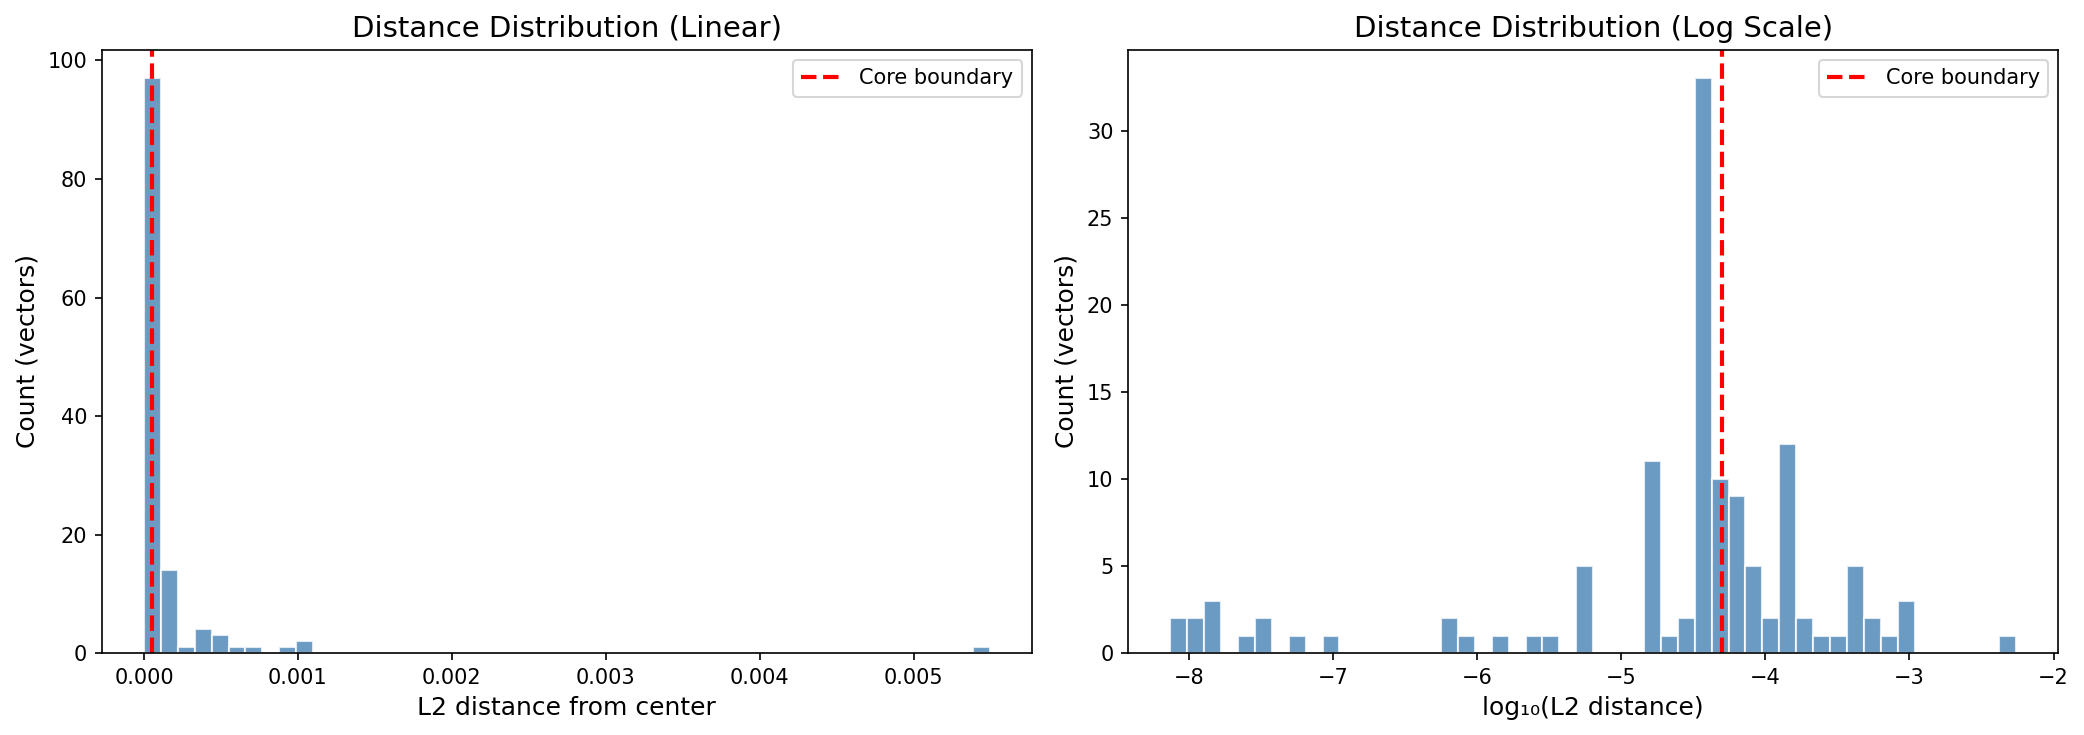

In [4]:
# Distance histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=150)

# Linear scale
ax = axes[0]
ax.hist(r, bins=50, color='steelblue', edgecolor='white', alpha=0.8)
ax.axvline(0.00005, color='red', linestyle='--', linewidth=2, label='Core boundary')
ax.set_xlabel('L2 distance from center', fontsize=12)
ax.set_ylabel('Count (vectors)', fontsize=12)
ax.set_title('Distance Distribution (Linear)', fontsize=14)
ax.legend()

# Log scale
ax = axes[1]
r_nonzero = r[r > 0]
ax.hist(np.log10(r_nonzero), bins=50, color='steelblue', edgecolor='white', alpha=0.8)
ax.axvline(np.log10(0.00005), color='red', linestyle='--', linewidth=2, label='Core boundary')
ax.set_xlabel('log₁₀(L2 distance)', fontsize=12)
ax.set_ylabel('Count (vectors)', fontsize=12)
ax.set_title('Distance Distribution (Log Scale)', fontsize=14)
ax.legend()

plt.tight_layout()
plt.savefig('../../../notebooks/analysis/frozen_smoke_geography_dist.png', dpi=150, bbox_inches='tight')
plt.show()

## Core vs Oort Cloud

In [5]:
CORE_BOUNDARY = 0.00005

core_mask = r < CORE_BOUNDARY
oort_mask = r >= CORE_BOUNDARY

# Vector counts
core_vectors = core_mask.sum()
oort_vectors = oort_mask.sum()

# Token counts
core_tokens = counts.numpy()[core_mask].sum()
oort_tokens = counts.numpy()[oort_mask].sum()

# Densities
core_density = core_tokens / core_vectors if core_vectors > 0 else 0
oort_density = oort_tokens / oort_vectors if oort_vectors > 0 else 0

print(f"CORE (L2 < {CORE_BOUNDARY}):")
print(f"  Vectors: {core_vectors}")
print(f"  Tokens: {core_tokens:,}")
print(f"  Density (tokens/vector): {core_density:.1f}")
print()
print(f"OORT CLOUD (L2 >= {CORE_BOUNDARY}):")
print(f"  Vectors: {oort_vectors}")
print(f"  Tokens: {oort_tokens}")
print(f"  Density (tokens/vector): {oort_density:.1f}")
print()
print(f"Density ratio (core/oort): {core_density/oort_density:.1f}x")

CORE (L2 < 5e-05):
  Vectors: 75
  Tokens: 2,159
  Density (tokens/vector): 28.8

OORT CLOUD (L2 >= 5e-05):
  Vectors: 50
  Tokens: 53
  Density (tokens/vector): 1.1

Density ratio (core/oort): 27.2x


In [6]:
# What's in the Oort Cloud?
oort_indices = np.where(oort_mask)[0]

print(f"Oort Cloud residents ({len(oort_indices)} vectors):")
print()

oort_data = []
for vec_idx in oort_indices:
    dist = r[vec_idx]
    n_tok = counts[vec_idx].item()
    
    # Find a token at this vector
    token_idx = neighborhood_indices[(inverse_indices == vec_idx).nonzero()[0]].item()
    decoded = tokenizer.decode([token_idx])
    
    oort_data.append({
        'Vec': vec_idx,
        'Dist': dist,
        'Tokens': n_tok,
        'Token ID': token_idx,
        'Decoded': repr(decoded)[:30]
    })

oort_df = pd.DataFrame(oort_data)
oort_df = oort_df.sort_values('Dist', ascending=False).reset_index(drop=True)

print(oort_df.head(20).to_string(index=False))
if len(oort_df) > 20:
    print(f"  ... and {len(oort_df) - 20} more")

Oort Cloud residents (50 vectors):



 Vec     Dist  Tokens  Token ID          Decoded
   0 0.005495       1     27487            '��取'
   1 0.001039       1    141553           'บอร์'
 122 0.001018       1    136461       'พร้อมกับ'
 124 0.000922       1    125869           'เร็ว'
   2 0.000732       1     83971 '$PostalCodesNL'
 121 0.000574       1    139765            'ช้า'
   7 0.000499       1    151145              '阮'
 115 0.000454       1    151929               ''
 116 0.000443       1    143045           ' อีก'
 123 0.000425       1    136755           'จันท'
   6 0.000424       1    148830              '晴'
 119 0.000385       1    148932              '魯'
 120 0.000364       1    125458           'ซึ่ง'
 117 0.000243       1    141989   'พรีเมียร์ลีก'
 112 0.000194       1    145341              'ί'
 110 0.000188       1    127974        'ปลอดภัย'
  14 0.000162       1    136401             'ปู'
   5 0.000149       1    133377           'เนีย'
   4 0.000148       1    125125             'สุ'
 107 0.000146       

## The Void

Between the core and the Oort Cloud, is there a gap? Let's bin by distance and look at density.

In [7]:
# Density as a function of distance
n_bins = 20
r_max = r.max() * 1.1
bin_edges = np.linspace(0, r_max, n_bins + 1)

print(f"{'Bin':>5} {'Range':>25} {'Vectors':>10} {'Tokens':>10} {'Density':>10}")
print("-" * 65)

for i in range(n_bins):
    lo, hi = bin_edges[i], bin_edges[i+1]
    mask = (r >= lo) & (r < hi)
    n_vec = mask.sum()
    n_tok = counts.numpy()[mask].sum()
    density = n_tok / n_vec if n_vec > 0 else 0
    
    if n_vec > 0:  # Only show non-empty bins
        print(f"{i+1:>5} [{lo:.6f}, {hi:.6f}) {n_vec:>10} {n_tok:>10,} {density:>10.1f}")

  Bin                     Range    Vectors     Tokens    Density
-----------------------------------------------------------------
    1 [0.000000, 0.000302)        112      2,199       19.6
    2 [0.000302, 0.000604)          8          8        1.0
    3 [0.000604, 0.000907)          1          1        1.0
    4 [0.000907, 0.001209)          3          3        1.0
   19 [0.005440, 0.005742)          1          1        1.0


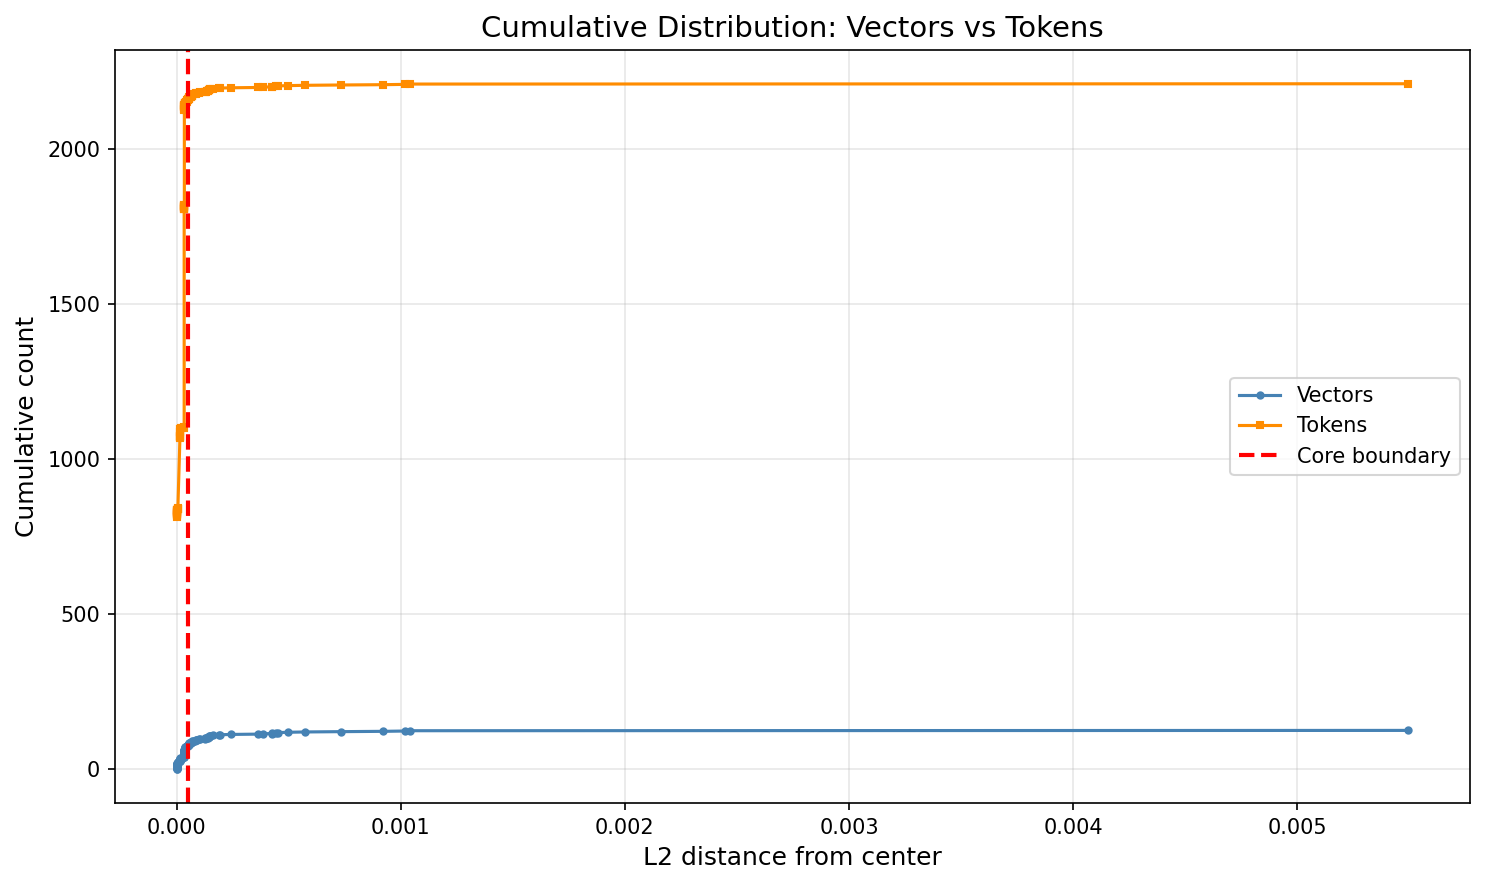

In [8]:
# Cumulative distribution
r_sorted = np.sort(r)
cumulative = np.arange(1, len(r_sorted) + 1)

# Token-weighted cumulative
sort_order = np.argsort(r)
counts_sorted = counts.numpy()[sort_order]
token_cumulative = np.cumsum(counts_sorted)

fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

ax.plot(r_sorted, cumulative, 'o-', color='steelblue', markersize=3, label='Vectors')
ax.plot(r_sorted, token_cumulative, 's-', color='darkorange', markersize=3, label='Tokens')
ax.axvline(CORE_BOUNDARY, color='red', linestyle='--', linewidth=2, label='Core boundary')

ax.set_xlabel('L2 distance from center', fontsize=12)
ax.set_ylabel('Cumulative count', fontsize=12)
ax.set_title('Cumulative Distribution: Vectors vs Tokens', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../../../notebooks/analysis/frozen_smoke_geography_cumulative.png', dpi=150, bbox_inches='tight')
plt.show()

## The Outlier

In [9]:
# The most distant vector
outlier_idx = np.argmax(r)
outlier_dist = r[outlier_idx]
outlier_count = counts[outlier_idx].item()

# Find token
outlier_token = neighborhood_indices[(inverse_indices == outlier_idx).nonzero()[0]].item()
outlier_decoded = tokenizer.decode([outlier_token])

# Second most distant
r_temp = r.copy()
r_temp[outlier_idx] = 0
second_idx = np.argmax(r_temp)
second_dist = r[second_idx]

print("THE OUTLIER")
print("=" * 50)
print(f"  Vector index: {outlier_idx}")
print(f"  L2 distance from center: {outlier_dist:.6f}")
print(f"  Token count: {outlier_count}")
print(f"  Token ID: {outlier_token}")
print(f"  Decoded: {repr(outlier_decoded)}")
print()
print(f"Gap to next closest:")
print(f"  Second place distance: {second_dist:.6f}")
print(f"  Gap ratio: {outlier_dist / second_dist:.1f}x")

THE OUTLIER
  Vector index: 0
  L2 distance from center: 0.005495
  Token count: 1
  Token ID: 27487
  Decoded: '��取'

Gap to next closest:
  Second place distance: 0.001039
  Gap ratio: 5.3x


## Vector Magnitudes

Do all vectors in the frozen smoke have similar magnitudes?

In [10]:
# Compute magnitudes
magnitudes = torch.norm(W_unique, dim=1).numpy()

print(f"Magnitude statistics:")
print(f"  Min: {magnitudes.min():.6f}")
print(f"  Max: {magnitudes.max():.6f}")
print(f"  Mean: {magnitudes.mean():.6f}")
print(f"  Std: {magnitudes.std():.6f}")
print(f"  CV (std/mean): {magnitudes.std()/magnitudes.mean()*100:.3f}%")
print()

# Compare core vs Oort Cloud magnitudes
core_mags = magnitudes[core_mask]
oort_mags = magnitudes[oort_mask]

print(f"Core magnitudes: [{core_mags.min():.6f}, {core_mags.max():.6f}]")
print(f"Oort Cloud magnitudes: [{oort_mags.min():.6f}, {oort_mags.max():.6f}]")

Magnitude statistics:
  Min: 0.370653
  Max: 0.370957
  Mean: 0.370915
  Std: 0.000024
  CV (std/mean): 0.007%

Core magnitudes: [0.370917, 0.370918]
Oort Cloud magnitudes: [0.370653, 0.370957]


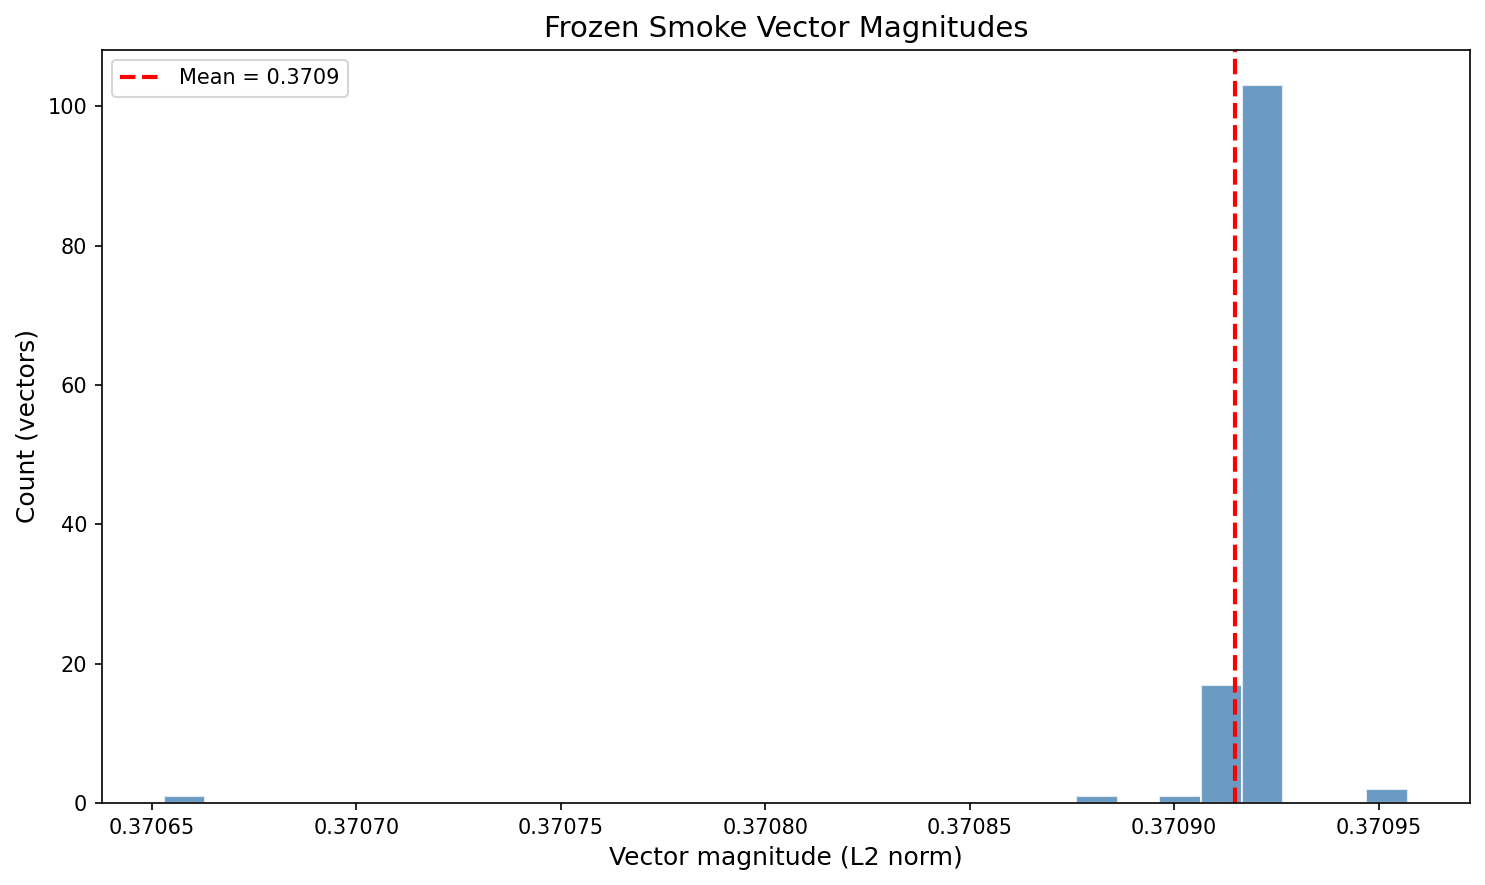

In [11]:
# Magnitude histogram
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

ax.hist(magnitudes, bins=30, color='steelblue', edgecolor='white', alpha=0.8)
ax.axvline(magnitudes.mean(), color='red', linestyle='--', linewidth=2, 
           label=f'Mean = {magnitudes.mean():.4f}')

ax.set_xlabel('Vector magnitude (L2 norm)', fontsize=12)
ax.set_ylabel('Count (vectors)', fontsize=12)
ax.set_title('Frozen Smoke Vector Magnitudes', fontsize=14)
ax.legend()

plt.tight_layout()
plt.savefig('../../../notebooks/analysis/frozen_smoke_geography_magnitudes.png', dpi=150, bbox_inches='tight')
plt.show()

## Extended Oort Cloud Search

Our selection (L∞ ≤ 5 exponents) only catches the closest Oort Cloud members. What's further out?

In [12]:
# Search full vocabulary for tokens in Oort Cloud distance range
W_float = W.float()
center_token = neighborhood_indices[(inverse_indices == center_idx).nonzero()[0]].item()
center_vec = W_float[center_token]

# Compute distances for ALL tokens
all_distances = torch.norm(W_float - center_vec, dim=1).numpy()

# Define Oort Cloud range
OORT_INNER = 0.005
OORT_OUTER = 0.05

oort_extended_mask = (all_distances >= OORT_INNER) & (all_distances < OORT_OUTER)
oort_extended_tokens = np.where(oort_extended_mask)[0]

print(f"Extended Oort Cloud ({OORT_INNER} ≤ L2 < {OORT_OUTER}):")
print(f"  Total tokens: {len(oort_extended_tokens)}")
print(f"  In our selection (L∞ ≤ 5 exp): {(oort_extended_mask & neighborhood_mask.numpy()).sum()}")
print(f"  Outside our selection: {len(oort_extended_tokens) - (oort_extended_mask & neighborhood_mask.numpy()).sum()}")

Extended Oort Cloud (0.005 ≤ L2 < 0.05):
  Total tokens: 87
  In our selection (L∞ ≤ 5 exp): 1
  Outside our selection: 86


In [13]:
# Sample extended Oort Cloud tokens
if len(oort_extended_tokens) > 0:
    # Sort by distance
    oort_ext_distances = all_distances[oort_extended_tokens]
    sorted_idx = np.argsort(oort_ext_distances)
    
    print("\nSample extended Oort Cloud residents:")
    print(f"{'Token':>8} {'Distance':>12} {'In Selection':>15} {'Decoded':>30}")
    print("-" * 70)
    
    for i in sorted_idx[:20]:
        tok_id = oort_extended_tokens[i]
        dist = oort_ext_distances[i]
        in_sel = "Yes" if neighborhood_mask[tok_id].item() else "No"
        decoded = repr(tokenizer.decode([tok_id]))[:30]
        print(f"{tok_id:>8} {dist:>12.6f} {in_sel:>15} {decoded:>30}")
    
    if len(oort_extended_tokens) > 20:
        print(f"  ... and {len(oort_extended_tokens) - 20} more")


Sample extended Oort Cloud residents:
   Token     Distance    In Selection                        Decoded
----------------------------------------------------------------------
   27487     0.005495             Yes                          '��取'
  151653     0.006882              No               '<|vision_end|>'
  151652     0.007598              No             '<|vision_start|>'
  142386     0.007800              No                     ' zwłaszc'
   88372     0.008590              No                  'useRalative'
  127734     0.009263              No                        'פייסב'
  136954     0.009575              No                         'טלוו'
  127572     0.014709              No                           'ו�'
   88371     0.016145              No                       'useRal'
  151300     0.016386              No                            '𝇠'
   78323     0.016789              No              ' thuisontvangst'
   51088     0.016825              No                         

## Visualization: 2D Projection

In [14]:
# Simple 2D projection using PCA
from sklearn.decomposition import PCA

# Center the data
W_centered = W_unique - W_unique.mean(dim=0)

# PCA
pca = PCA(n_components=2)
coords_2d = pca.fit_transform(W_centered.numpy())

print(f"Variance explained: {pca.explained_variance_ratio_.sum()*100:.1f}%")
print(f"  PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
print(f"  PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")

Variance explained: 88.1%
  PC1: 84.3%
  PC2: 3.8%


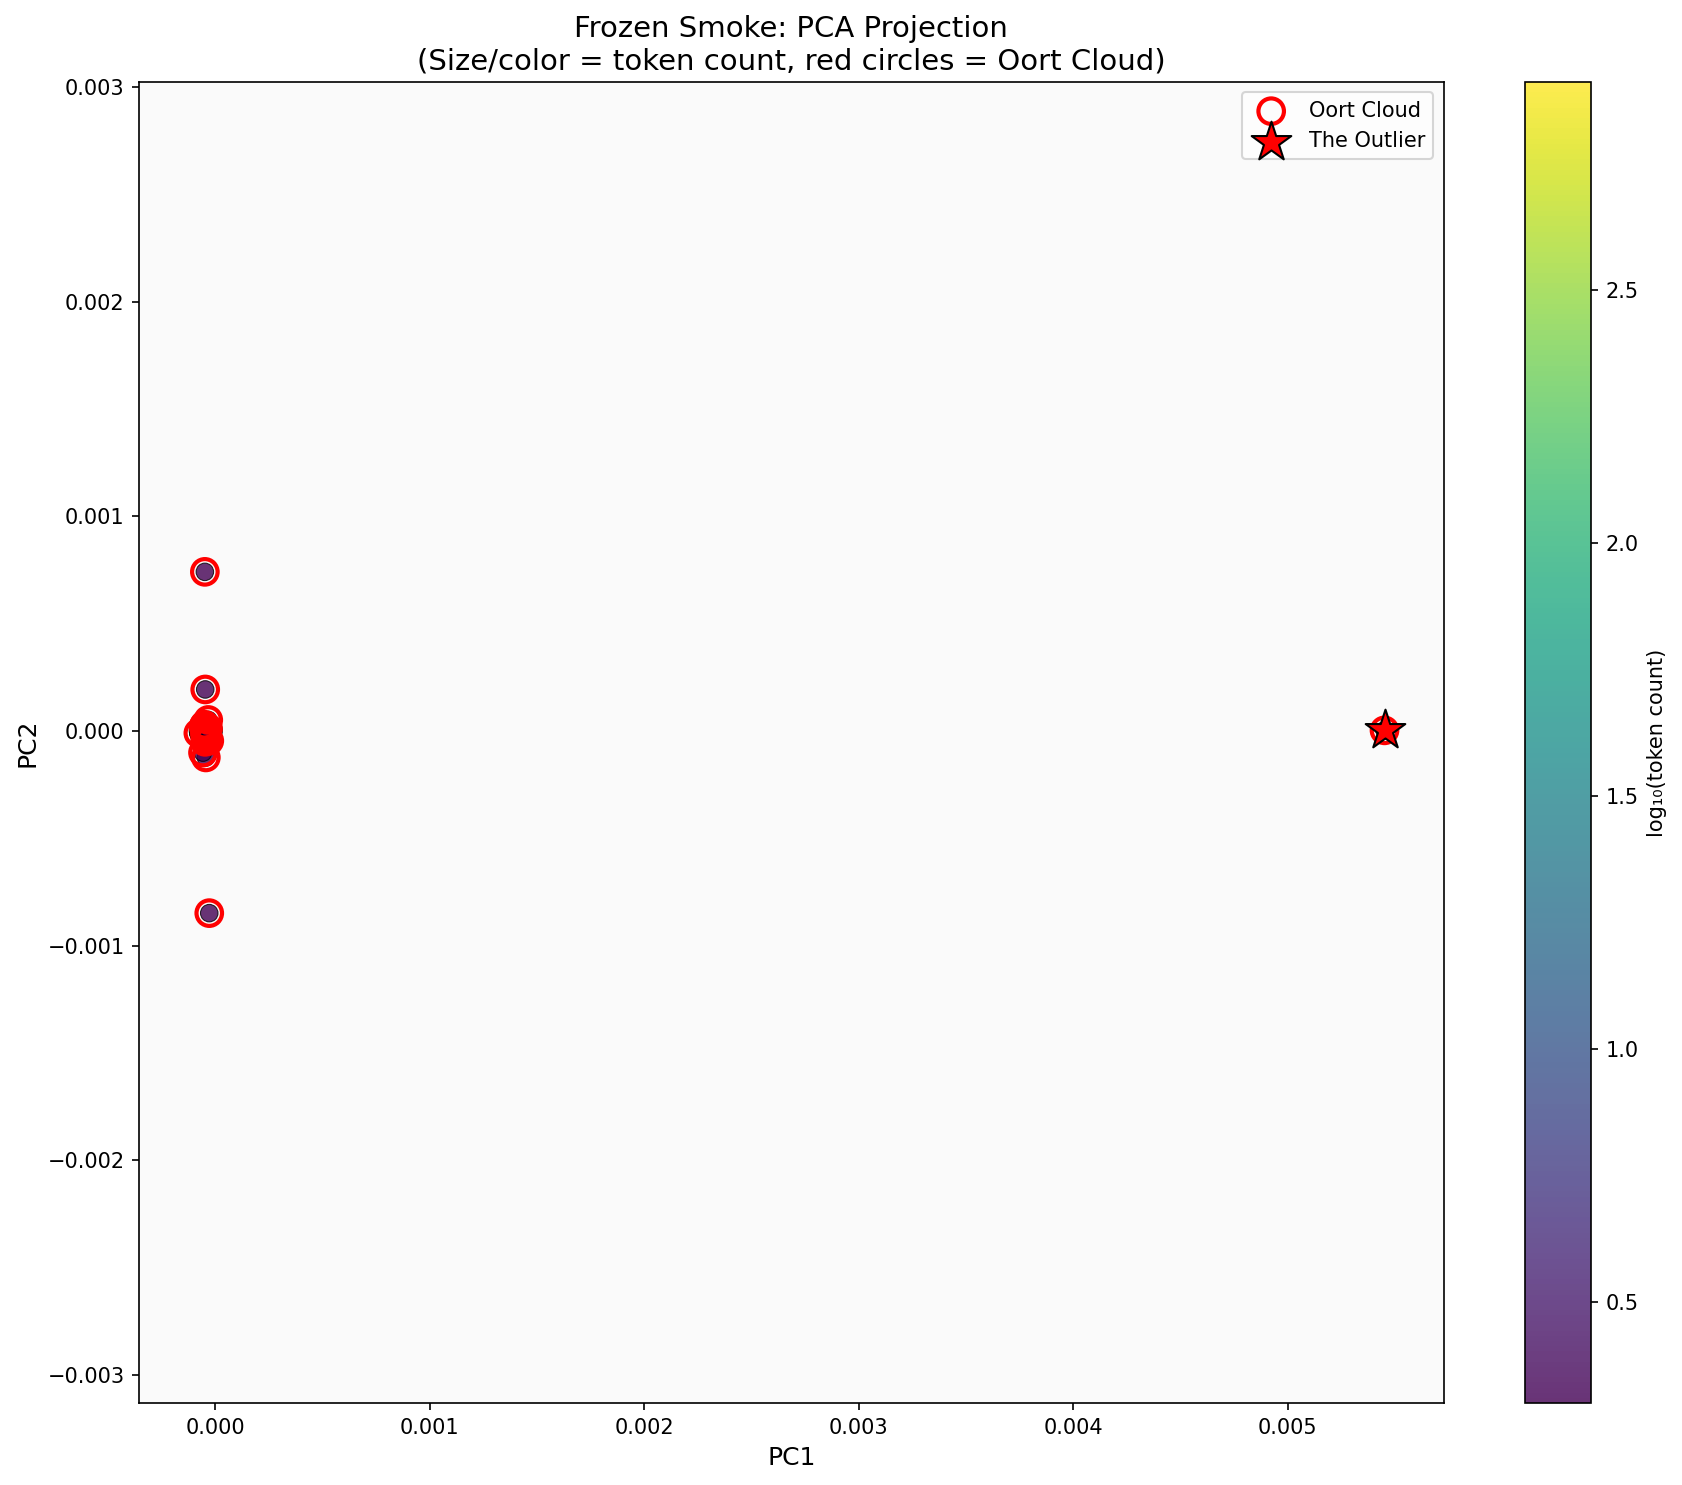

In [15]:
# Plot
fig, ax = plt.subplots(figsize=(12, 10), dpi=150)
ax.set_facecolor('#fafafa')

# Color by token count (log scale)
log_counts = np.log10(counts.numpy() + 1)
max_log = log_counts.max()

# Size by token count
sizes = 50 + 200 * (log_counts / max_log)

# Core vs Oort Cloud
scatter = ax.scatter(coords_2d[:, 0], coords_2d[:, 1], 
                     c=log_counts, cmap='viridis', s=sizes,
                     edgecolors='black', linewidths=0.5, alpha=0.8)

# Mark Oort Cloud
ax.scatter(coords_2d[oort_mask, 0], coords_2d[oort_mask, 1],
           facecolors='none', edgecolors='red', s=150, linewidths=2,
           label='Oort Cloud')

# Mark The Outlier
ax.scatter(coords_2d[outlier_idx, 0], coords_2d[outlier_idx, 1],
           marker='*', s=400, c='red', edgecolors='black', linewidths=1,
           label='The Outlier', zorder=10)

cbar = plt.colorbar(scatter, ax=ax, label='log₁₀(token count)')
ax.set_xlabel('PC1', fontsize=12)
ax.set_ylabel('PC2', fontsize=12)
ax.set_title('Frozen Smoke: PCA Projection\n(Size/color = token count, red circles = Oort Cloud)', fontsize=14)
ax.legend(loc='upper right')
ax.axis('equal')

plt.tight_layout()
plt.savefig('../../../notebooks/analysis/frozen_smoke_geography_pca.png', dpi=150, bbox_inches='tight')
plt.show()

## Summary

In [16]:
print("=" * 60)
print("FROZEN SMOKE GEOGRAPHY SUMMARY")
print("=" * 60)
print()
print(f"SPATIAL ZONES:")
print(f"  Core (L2 < {CORE_BOUNDARY}):")
print(f"    Vectors: {core_vectors}")
print(f"    Tokens: {core_tokens:,}")
print(f"    Density: {core_density:.1f} tokens/vector")
print()
print(f"  Oort Cloud (L2 >= {CORE_BOUNDARY}):")
print(f"    Vectors: {oort_vectors}")
print(f"    Tokens: {oort_tokens}")
print(f"    Density: {oort_density:.1f} tokens/vector")
print()
print(f"THE VOID:")
print(f"  Core → Oort density drop: {core_density/oort_density:.0f}x")
print(f"  Transition is SHARP (no gradient)")
print()
print(f"THE OUTLIER:")
print(f"  Token: {outlier_token} ({repr(outlier_decoded)})")
print(f"  Distance: {outlier_dist:.6f}")
print(f"  Gap to second place: {outlier_dist/second_dist:.1f}x")
print()
print(f"MAGNITUDES:")
print(f"  Range: [{magnitudes.min():.4f}, {magnitudes.max():.4f}]")
print(f"  Variation (CV): {magnitudes.std()/magnitudes.mean()*100:.3f}%")
print()
print(f"EXTENDED OORT CLOUD ({OORT_INNER} - {OORT_OUTER}):")
print(f"  Total tokens: {len(oort_extended_tokens)}")

FROZEN SMOKE GEOGRAPHY SUMMARY

SPATIAL ZONES:
  Core (L2 < 5e-05):
    Vectors: 75
    Tokens: 2,159
    Density: 28.8 tokens/vector

  Oort Cloud (L2 >= 5e-05):
    Vectors: 50
    Tokens: 53
    Density: 1.1 tokens/vector

THE VOID:
  Core → Oort density drop: 27x
  Transition is SHARP (no gradient)

THE OUTLIER:
  Token: 27487 ('��取')
  Distance: 0.005495
  Gap to second place: 5.3x

MAGNITUDES:
  Range: [0.3707, 0.3710]
  Variation (CV): 0.007%

EXTENDED OORT CLOUD (0.005 - 0.05):
  Total tokens: 87
